# Bird Classification


Importing necessary libraries


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers

The image size is 500 by 333 pixels


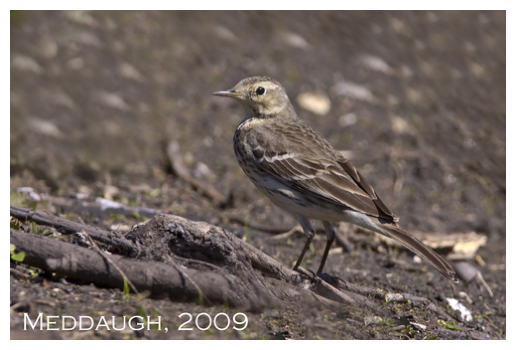

In [20]:
img = Image.open('/content/drive/MyDrive/bird-classification/Train/American_Pipit/American_Pipit_0006_99857.jpg')
print(f'The image size is {img.size[0]} by {img.size[1]} pixels')
plt.imshow(img)
plt.axis('off')
plt.show()

## 1. Loading and batching the images


In [33]:
base_dir_train = '/content/drive/MyDrive/bird-classification/Train'
train = image_dataset_from_directory(
    base_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 10,
    seed = 1234,
    #image_size = (224, 224),
    shuffle = True
    )

base_dir_test = '/content/drive/MyDrive/bird-classification/Test'
test = image_dataset_from_directory(
    base_dir_test,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 10,
    image_size = (224, 224),
    seed =1234
)

train_class_names = train.class_names
test_class_names = test.class_names



Found 9414 files belonging to 200 classes.
Found 2340 files belonging to 198 classes.


## Exploratory Data Analysis

In [24]:
# Display image to see our images
def display_images(class_names, image_batch, label_batch):
  plt.figure(figsize=(18, 6))
  for i in range(len(image_batch)):
    ax = plt.subplot(1, len(image_batch), i + 1)
    img = image_batch[i].numpy().astype('uint8')
    lbl = class_names[int(label_batch[i])]
    plt.imshow(img)
    plt.title(lbl)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

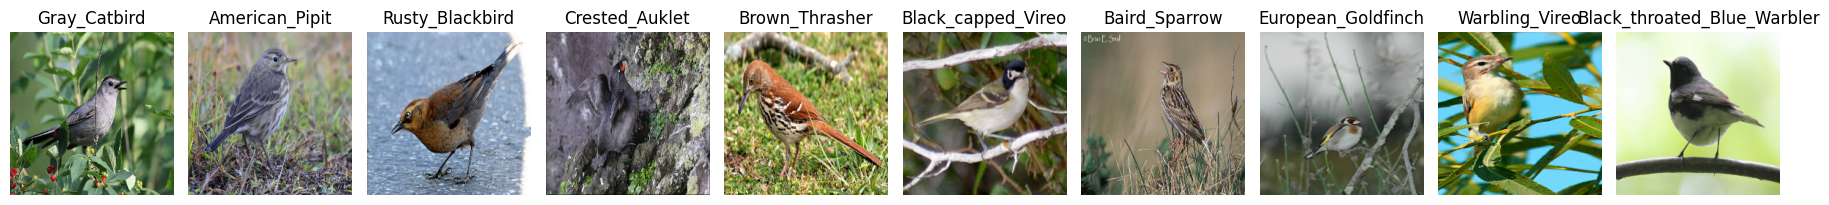

In [25]:
for image_batch, label_batch in train.take(1):
  display_images(train_class_names, image_batch, label_batch)

Lets explore the class distribution of our data. Major class imbalance can affect our CNN model performance when we have multiple class, its can be biased towards majority class as it optimizes for overall Accuracy. We can see high accuracy but low precision and recall.

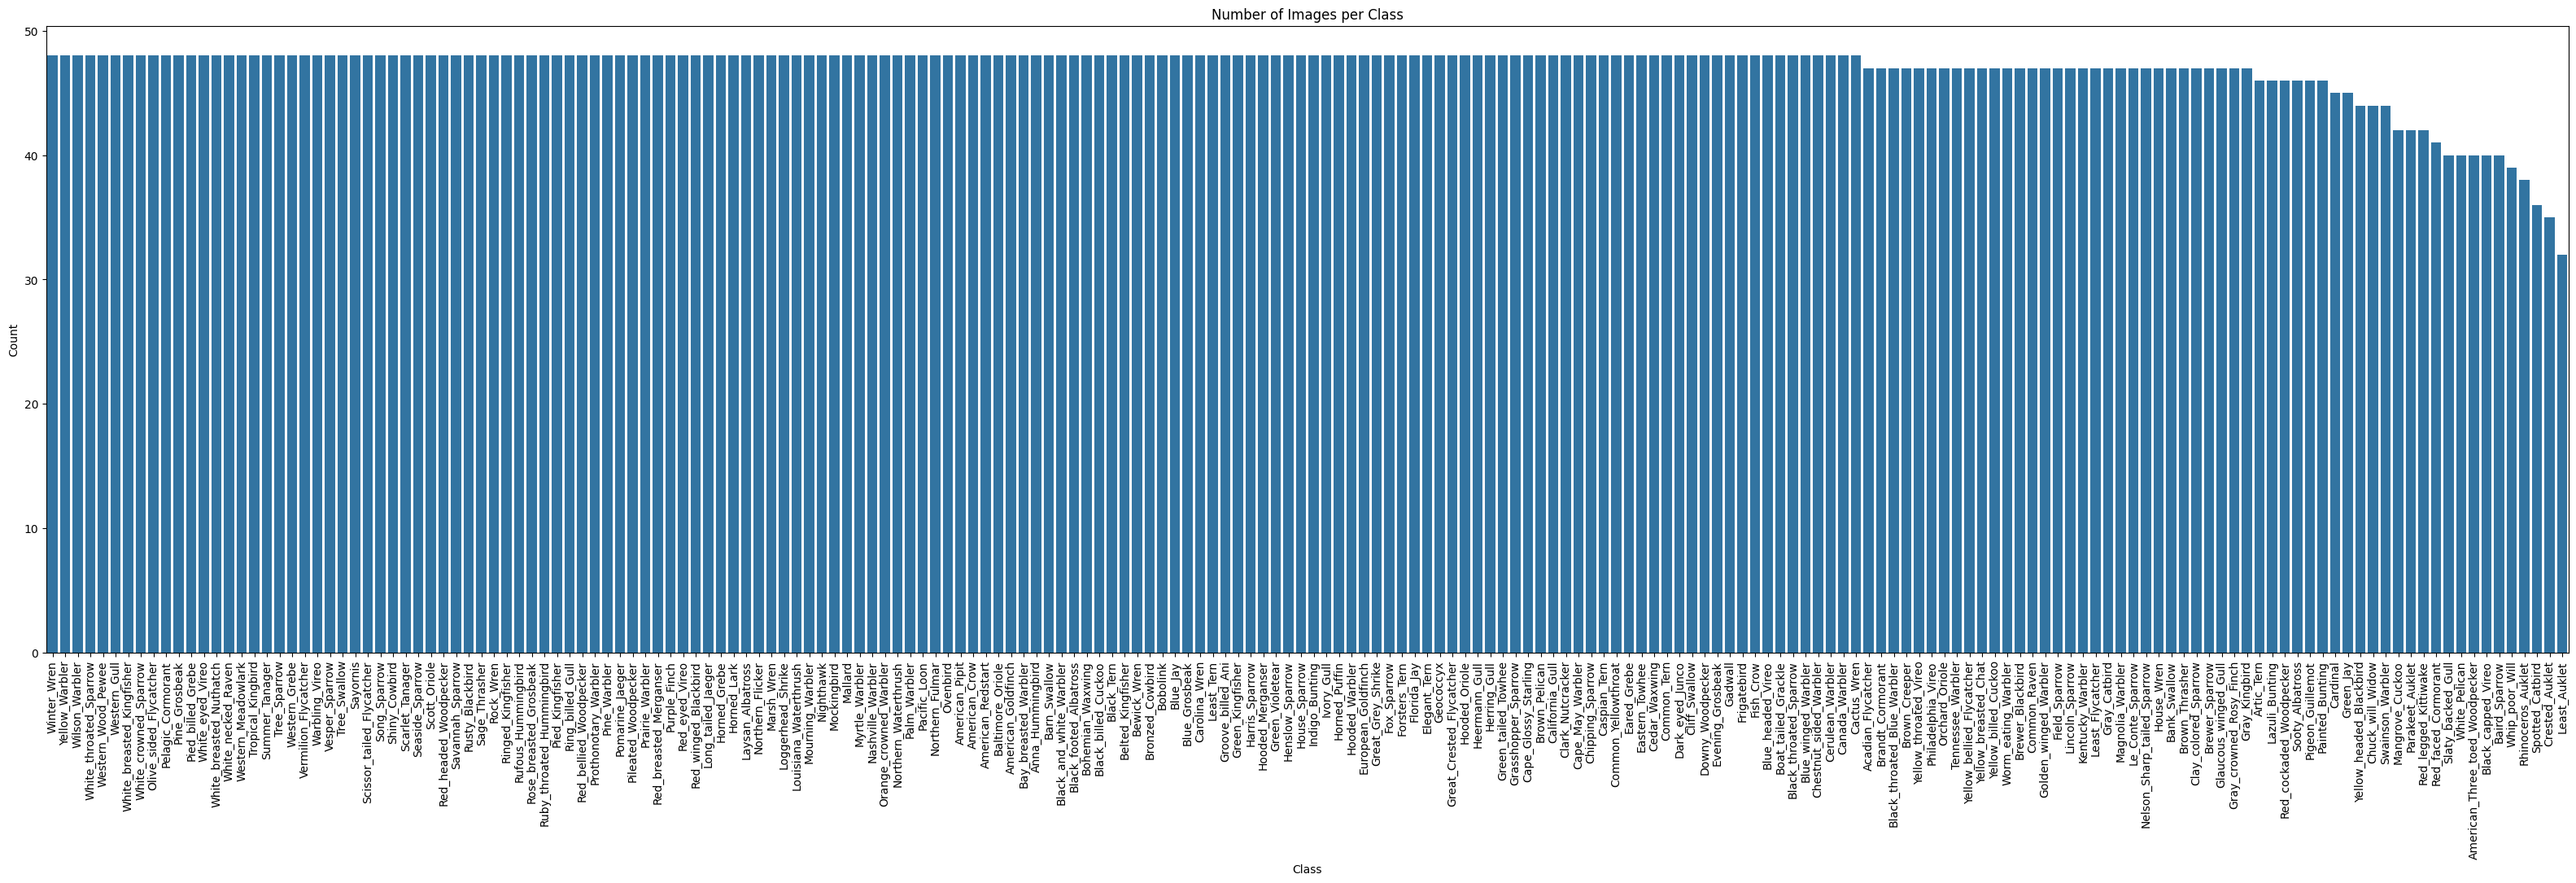

In [26]:
# Exploring class distribution of our data
classes = os.listdir(base_dir_train)

# Count images per class
class_counts = {class_name: len(os.listdir(os.path.join(base_dir_train, class_name)))
                for class_name in classes}

# Plot
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df = df.sort_values(by='Count', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 10))
sns.barplot(data=df, x='Class', y='Count')
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.show()

Overall it seems like our train data is evenly distributed among different class and there is not extremely worrisome class imbalance in any class.



## Pre- processing Images

Resizing and Normalizing

Cropping and resizing

In [34]:
# Cropping images
cropped_images = image_dataset_from_directory(
    base_dir_train,
    labels = 'inferred',
    label_mode = 'int',
    crop_to_aspect_ratio = True,
    image_size = (224, 224),
    batch_size = 10,
    seed = 1234
)

Found 9414 files belonging to 200 classes.


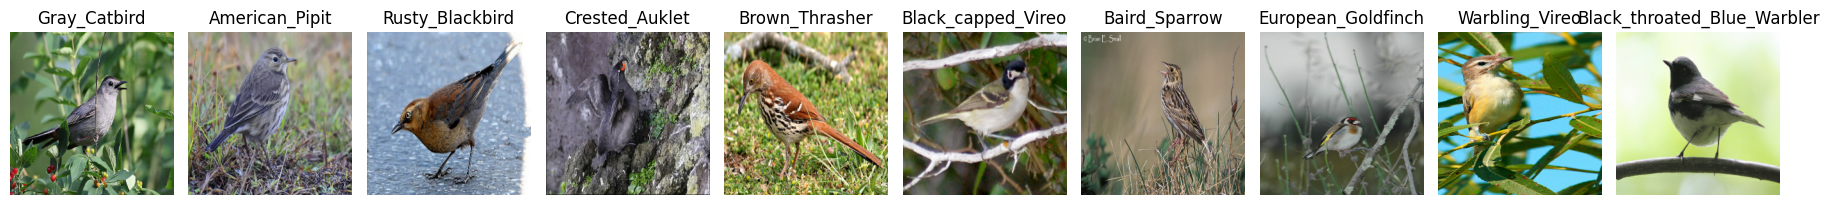

In [35]:
# Lets look at the images after cropping
for image_batch, label_batch in train.take(1):
  display_images(train_class_names, image_batch, label_batch)


Augment images

In [62]:
augmentation_layer = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandAugment(
        value_range = (0, 255),
        num_ops = 2,
        factor = 0.5,
        interpolation = 'bilinear',
        seed = 1234
    )
])

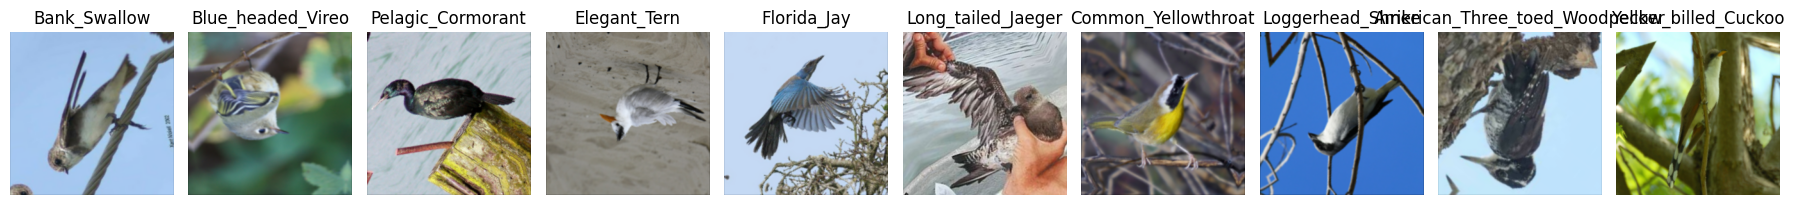

In [63]:
geom_augmented_images = train.map(lambda x, label : (augmentation_layer(x), label))

for image_batch, label_batch in geom_augmented_images.take(1):
  display_images(train_class_names, image_batch, label_batch)

In [69]:
model = keras.Sequential([

    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'), # kernel size = size of the window moving
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size =(2,2)),
    layers.Dropout(rate = 0.25),

    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Dropout(rate = 0.25),

    layers.Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Dropout(rate = 0.25),

    layers.Flatten(),
    layers.Dense(units = 512, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.5),
    layers.Dense(units = 200, activation = 'softmax')
])

In [70]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [71]:
val_size = 0.1  # 10% for validation
total_batches = tf.data.experimental.cardinality(train).numpy()
val_batches = int(val_size * total_batches)

# Shuffle and split
train_ds = train.skip(val_batches)
val_ds = train.take(val_batches)

In [ ]:
history = model.fit(train_ds,
                    epochs = 10,
                    batch_size = 128,
                    validation_data = val_ds)

Epoch 1/10
